# Histopathologic Cancer Detection

The goal of this Kaggle competition is to create an algorithm to identify metastatic cancer in small image patches. The Kaggle competition is availble here: https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview

From the data overview, we learn that images in the training set are only identified as class '1' when cancer is detected in the middle 32x32 pixels. This means we can use convolutional techniques that result in loss of features outside that area.

# Initializaiton

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, models
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
initial_df = pd.read_csv('/content/Dataset/train_labels.csv', dtype=str)
train_img = '/content/Dataset/train'
test_img = '/content/Dataset/test'
test_df = pd.read_csv('/content/Dataset/sample_submission.csv', dtype=str)

In [ ]:
initial_df['file'] = initial_df['id'] + '.tif'
test_df['file'] = test_df['id'] + '.tif'

# Exploratory Analysis
Inspect an example image, get image size, and evaluate the distribution of labels.

In [ ]:
initial_df.head()

,id,label,file
0,f38a6374c348f90b587e046aac6079959adf3835,0,f38a6374c348f90b587e046aac6079959adf3835.tif
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
2,755db6279dae599ebb4d39a9123cce439965282d,0,755db6279dae599ebb4d39a9123cce439965282d.tif
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
4,068aba587a4950175d04c680d38943fd488d6a9d,0,068aba587a4950175d04c680d38943fd488d6a9d.tif


In [ ]:
initial_df.describe()

,id,label
count,220025,220025
unique,220025,2
top,a81f84895ddcd522302ddf34be02eb1b3e5af1cb,0
freq,1,130908


Image Shape = (96, 96, 3)


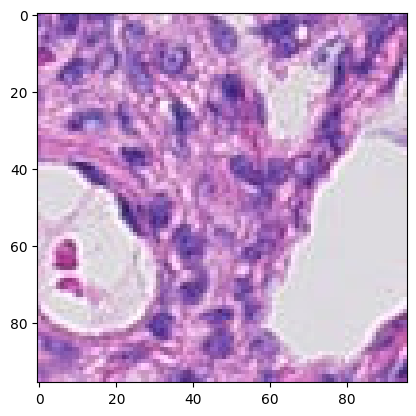

In [ ]:
example_path = "/content/Dataset/train/a81f84895ddcd522302ddf34be02eb1b3e5af1cb.tif"
example_img = Image.open(example_path)
example_array = np.array(example_img)
print(f"Image Shape = {example_array.shape}")
plt.imshow(example_img)
plt.show()

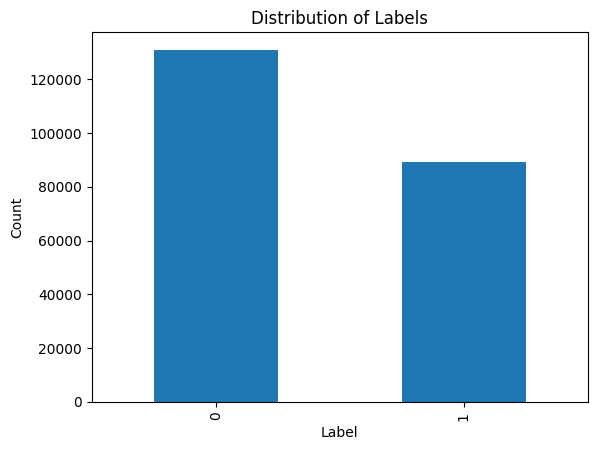

In [ ]:
# Count the occurrences of each class
class_counts = initial_df['label'].value_counts()

# Create a bar plot
class_counts.plot(kind='bar')

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')

# Show the plot
plt.show()

In [ ]:
train_df, valid_df = train_test_split(initial_df, test_size=0.2, random_state=121, stratify=initial_df.label)

print(train_df.shape)
print(valid_df.shape)

(176020, 3)
(44005, 3)


We have over 200,000 images to work with - plenty of data to train a model. We may need to sample the images for training if the volume becomes an issue. Each image is 96 pixels square. Considering that only the middle 32 pixel square contributes to the classification, we are safe to use convolutional techniques that result in data loss around the edges. The classes are also fairly balanced (60% '0' and 40% '1') so I won't take any special precautions other than stratifying by label when I create the validation dataset.

# Image Handling Prep

In [ ]:
train_image = ImageDataGenerator(rescale=1/255)
valid_image = ImageDataGenerator(rescale=1/255)
test_image = ImageDataGenerator(rescale=1/255)

In [ ]:
img_h = 96
img_w = 96
batch_size = 128

train_flow = train_image.flow_from_dataframe(
    dataframe=train_df,
    directory=train_img,
    batch_size=batch_size,
    x_col='file',
    y_col='label',
    class_mode='binary',
    target_size=(img_h, img_w),
    shuffle=True,
    seed=121
)

valid_flow = valid_image.flow_from_dataframe(
    dataframe=valid_df,
    directory=train_img,
    batch_size=batch_size,
    x_col='file',
    y_col='label',
    class_mode='binary',
    target_size=(img_h, img_w),
    shuffle=True,
    seed=121
)

test_flow = test_image.flow_from_dataframe(
    dataframe=test_df,
    directory=test_img,
    batch_size=batch_size,
    x_col='file',
    y_col=None,
    class_mode=None,
    target_size=(img_h, img_w),
    shuffle=False)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.
Found 57458 validated image filenames.


# Initial Model Creation

This basic architecture uses alternating 3x3 convolutional layers and max pool layers. Convolutional layers serve to extract increasingly complex features from the images. Max pooling is an efficient way to reduce features and provides some translation invariance. The flatten layers serves to transition from feature extraction to the classification task. Dense layers require 1-dimensional input. The prediction is made in the final dense layer.

In [ ]:
model = models.Sequential()
model.add(layers.Input(shape=(img_h, img_w, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 20, 20, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,638,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,694,849 (6.47 MB)

 Trainable params: 1,694,849 (6.47 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC'])

history = model.fit(train_flow, epochs=10,
                    validation_data=valid_flow)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 338s 241ms/step - AUC: 0.8329 - accuracy: 0.7632 - loss: 0.4867 - val_AUC: 0.9054 - val_accuracy: 0.8316 - val_loss: 0.3842
Epoch 2/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 252s 183ms/step - AUC: 0.9070 - accuracy: 0.8357 - loss: 0.3766 - val_AUC: 0.9385 - val_accuracy: 0.8667 - val_loss: 0.3156
Epoch 3/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 233s 169ms/step - AUC: 0.9353 - accuracy: 0.8673 - loss: 0.3164 - val_AUC: 0.9527 - val_accuracy: 0.8887 - val_loss: 0.2726
Epoch 4/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 226s 164ms/step - AUC: 0.9517 - accuracy: 0.8877 - loss: 0.2735 - val_AUC: 0.9561 - val_accuracy: 0.8949 - val_loss: 0.2640
Epoch 5/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 234s 170ms/step - AUC: 0.9623 - accuracy: 0.9015 - loss: 0.2420 - val_AUC: 0.9629 - val_accuracy: 0.9045 - val_loss: 0.2385
Epoch 6/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 251s 182ms/step - AUC: 0.9714 - accuracy: 0.9169 - loss: 0.2105 - val_AUC: 0.9640 - val_accuracy: 0.9079 - val_loss: 0.2356
Epoc

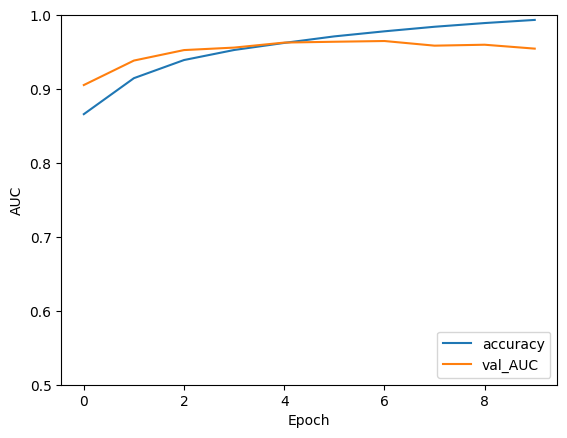

In [ ]:
plt.plot(history.history['AUC'], label='accuracy')
plt.plot(history.history['val_AUC'], label = 'val_AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

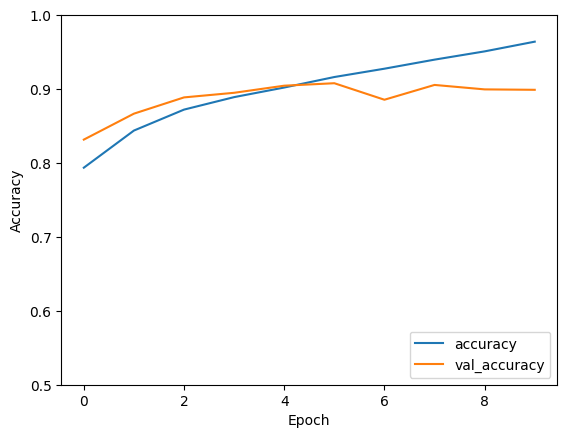

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
test_pred = model.predict(test_flow)
test_pred = test_pred.reshape(-1)
test_pred.shape

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 81s 176ms/step


(57458,)

In [ ]:
test_df['label'] = test_pred
submit_df = test_df[['id', 'label']]
submit_df.to_csv('/content/submission-simple.csv', index=False)

# 0.8965 test score.

# Early Stopping

The model performed really well, with a maximum validation AUC of of 0.96 and a test score of 0.8965 when submitted to Kaggle. We do see a bit of overfitting and a need for early stopping - preferably after epoch 7. In the next section, I'll add in early stopping.

In [ ]:
model = models.Sequential()
model.add(layers.Input(shape=(img_h, img_w, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [ ]:
# Adding in Early Stopping
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC'])

callback = EarlyStopping(monitor='val_AUC',
                         patience=1,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=2
)

history = model.fit(train_flow, epochs=10,
                    validation_data=valid_flow, callbacks=[callback])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 346s 247ms/step - AUC: 0.8375 - accuracy: 0.7653 - loss: 0.4849 - val_AUC: 0.9051 - val_accuracy: 0.8321 - val_loss: 0.3903
Epoch 2/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 267s 194ms/step - AUC: 0.9117 - accuracy: 0.8401 - loss: 0.3669 - val_AUC: 0.9382 - val_accuracy: 0.8596 - val_loss: 0.3256
Epoch 3/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 294s 174ms/step - AUC: 0.9367 - accuracy: 0.8668 - loss: 0.3129 - val_AUC: 0.9472 - val_accuracy: 0.8781 - val_loss: 0.2908
Epoch 4/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 247s 179ms/step - AUC: 0.9538 - accuracy: 0.8893 - loss: 0.2672 - val_AUC: 0.9565 - val_accuracy: 0.8929 - val_loss: 0.2603
Epoch 5/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 238s 173ms/step - AUC: 0.9650 - accuracy: 0.9046 - loss: 0.2327 - val_AUC: 0.9632 - val_accuracy: 0.9016 - val_loss: 0.2426
Epoch 6/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 240s 174ms/step - AUC: 0.9739 - accuracy: 0.9204 - loss: 0.2009 - val_AUC: 0.9607 - val_accuracy: 0.8974 - val_loss: 0.2689


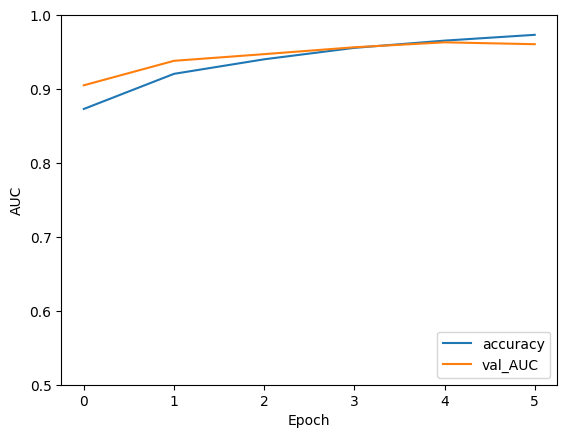

In [ ]:
plt.plot(history.history['AUC'], label='accuracy')
plt.plot(history.history['val_AUC'], label = 'val_AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

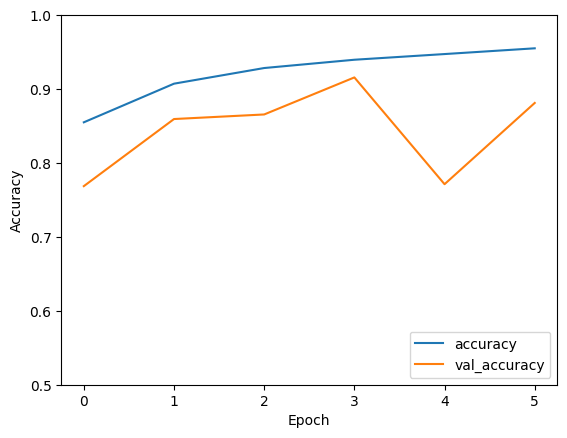

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
test_pred = model.predict(test_flow)
test_pred = test_pred.reshape(-1)
test_df['label'] = test_pred
submit_df = test_df[['id', 'label']]
submit_df.to_csv('/content/submission-simple-early.csv', index=False)

# 0.9213 test score.

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 101s 221ms/step


# More Complex Model Architecture

The update model architecture follows the same general pattern but I've added batch normalization between the convolutional and pooling layers. I added an additional convolution layer and max filter size of the convolutional layers now goes to 256. Finally, I added a dropout layer between the next-to-last dense layer and the output layer. The batch normalization helps accelerate and stabilize training while the dropout layer curbs overfitting. Dropout layers are typically added amongst dense layers but can also be added after convolutional layers.

In [ ]:
model = models.Sequential()
model.add(layers.Input(shape=(img_h, img_w, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 94, 94, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 20, 20, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         262,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,955,909 (7.46 MB)

 Trainable params: 651,649 (2.49 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 1,303,300 (4.97 MB)

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC'])

callback = EarlyStopping(monitor='val_AUC',
                         patience=2,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=2
)

history = model.fit(train_flow, epochs=10,
                    validation_data=valid_flow, callbacks=[callback])

Epoch 1/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 324s 229ms/step - AUC: 0.8880 - accuracy: 0.8247 - loss: 0.4393 - val_AUC: 0.8651 - val_accuracy: 0.7686 - val_loss: 0.5453
Epoch 2/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 257s 187ms/step - AUC: 0.9562 - accuracy: 0.9006 - loss: 0.2579 - val_AUC: 0.9310 - val_accuracy: 0.8594 - val_loss: 0.3794
Epoch 3/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 296s 215ms/step - AUC: 0.9737 - accuracy: 0.9262 - loss: 0.1984 - val_AUC: 0.9397 - val_accuracy: 0.8656 - val_loss: 0.3177
Epoch 4/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 252s 183ms/step - AUC: 0.9812 - accuracy: 0.9401 - loss: 0.1652 - val_AUC: 0.9708 - val_accuracy: 0.9157 - val_loss: 0.2128
Epoch 5/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 260s 189ms/step - AUC: 0.9851 - accuracy: 0.9470 - loss: 0.1463 - val_AUC: 0.7532 - val_accuracy: 0.7713 - val_loss: 1.9193
Epoch 6/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 263s 190ms/step - AUC: 0.9891 - accuracy: 0.9563 - loss: 0.1233 - val_AUC: 0.9431 - val_accuracy: 0.8812 - val_loss: 0.3329


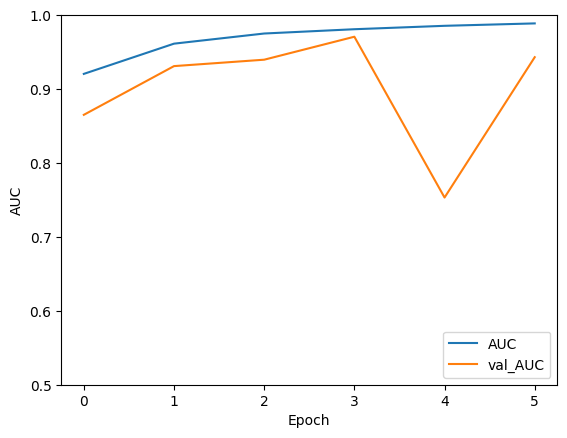

In [ ]:
plt.plot(history.history['AUC'], label='AUC')
plt.plot(history.history['val_AUC'], label = 'val_AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

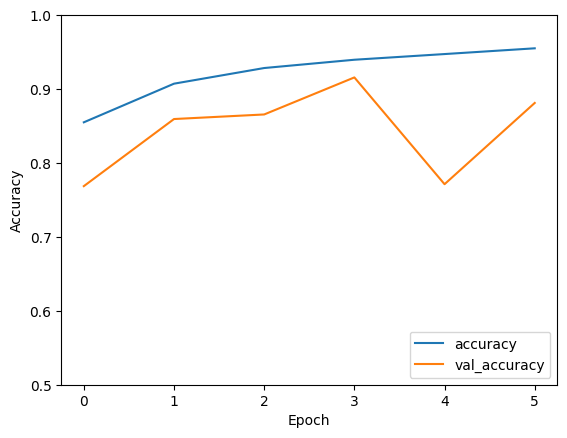

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
test_pred = model.predict(test_flow)
test_pred = test_pred.reshape(-1)
test_df['label'] = test_pred
submit_df = test_df[['id', 'label']]
submit_df.to_csv('/content/submission-complex-early.csv', index=False)

# Test score 0.939

449/449 ━━━━━━━━━━━━━━━━━━━━ 103s 225ms/step


# Optimizer Experimentation

I've decided to stick with the more complex model and see how the optimizer affects model performance. The lamb optimizer adds a trust ratio that scales the learning rate. It is designed to perform well with large batch sizes and may improve performance because I'm using a batch size of 128.

I also try the NAdam optimizer which is Adam with Nesterov momentum which anticipates future gradients.

In [ ]:
from tensorflow.keras.optimizers import Lamb

optimizer = Lamb(learning_rate=0.001, weight_decay=0.01)

In [ ]:
model = models.Sequential()
model.add(layers.Input(shape=(img_h, img_w, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [ ]:
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC'])

callback = EarlyStopping(monitor='val_AUC',
                         patience=2,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=2
)

history = model.fit(train_flow, epochs=10,
                    validation_data=valid_flow, callbacks=[callback])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 398s 279ms/step - AUC: 0.8749 - accuracy: 0.8069 - loss: 0.4363 - val_AUC: 0.9292 - val_accuracy: 0.8333 - val_loss: 0.3767
Epoch 2/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 281s 204ms/step - AUC: 0.9515 - accuracy: 0.8881 - loss: 0.2743 - val_AUC: 0.9420 - val_accuracy: 0.8745 - val_loss: 0.3148
Epoch 3/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 299s 217ms/step - AUC: 0.9687 - accuracy: 0.9146 - loss: 0.2190 - val_AUC: 0.9569 - val_accuracy: 0.8924 - val_loss: 0.2640
Epoch 4/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 263s 191ms/step - AUC: 0.9771 - accuracy: 0.9281 - loss: 0.1854 - val_AUC: 0.9659 - val_accuracy: 0.8976 - val_loss: 0.2568
Epoch 5/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 284s 207ms/step - AUC: 0.9827 - accuracy: 0.9385 - loss: 0.1612 - val_AUC: 0.9679 - val_accuracy: 0.9066 - val_loss: 0.2616
Epoch 6/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 270s 196ms/step - AUC: 0.9872 - accuracy: 0.9483 - loss: 0.1384 - val_AUC: 0.8884 - val_accuracy: 0.8317 - val_loss: 0.5375
Epoc

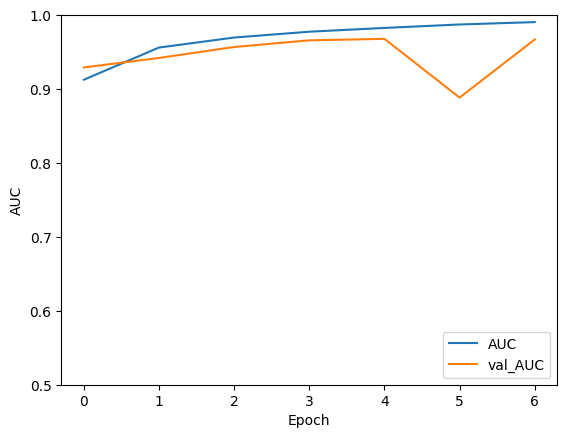

In [ ]:
plt.plot(history.history['AUC'], label='AUC')
plt.plot(history.history['val_AUC'], label = 'val_AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

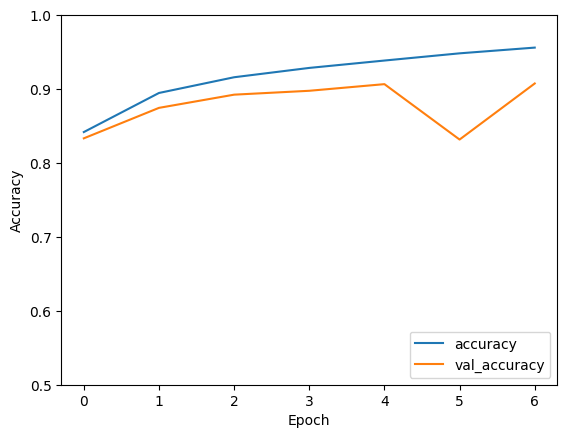

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
test_pred = model.predict(test_flow)
test_pred = test_pred.reshape(-1)
test_df['label'] = test_pred
submit_df = test_df[['id', 'label']]
submit_df.to_csv('/content/submission-complex-early-lamb.csv', index=False)

# 0.9363 test score

449/449 ━━━━━━━━━━━━━━━━━━━━ 100s 217ms/step


In [ ]:
model = models.Sequential()
model.add(layers.Input(shape=(img_h, img_w, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [ ]:
# NAdam

model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC'])

callback = EarlyStopping(monitor='val_AUC',
                         patience=2,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=2
)

history = model.fit(train_flow, epochs=10,
                    validation_data=valid_flow, callbacks=[callback])

Epoch 1/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 325s 230ms/step - AUC: 0.8911 - accuracy: 0.8264 - loss: 0.4221 - val_AUC: 0.8111 - val_accuracy: 0.7691 - val_loss: 1.0143
Epoch 2/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 292s 212ms/step - AUC: 0.9647 - accuracy: 0.9114 - loss: 0.2313 - val_AUC: 0.9626 - val_accuracy: 0.8817 - val_loss: 0.3390
Epoch 3/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 271s 197ms/step - AUC: 0.9766 - accuracy: 0.9313 - loss: 0.1862 - val_AUC: 0.7662 - val_accuracy: 0.7425 - val_loss: 1.2885
Epoch 4/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 330s 203ms/step - AUC: 0.9830 - accuracy: 0.9425 - loss: 0.1565 - val_AUC: 0.9638 - val_accuracy: 0.8972 - val_loss: 0.2961
Epoch 5/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 286s 208ms/step - AUC: 0.9870 - accuracy: 0.9520 - loss: 0.1356 - val_AUC: 0.9407 - val_accuracy: 0.8610 - val_loss: 0.3930
Epoch 6/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 279s 203ms/step - AUC: 0.9908 - accuracy: 0.9587 - loss: 0.1135 - val_AUC: 0.9013 - val_accuracy: 0.8430 - val_loss: 0.6106


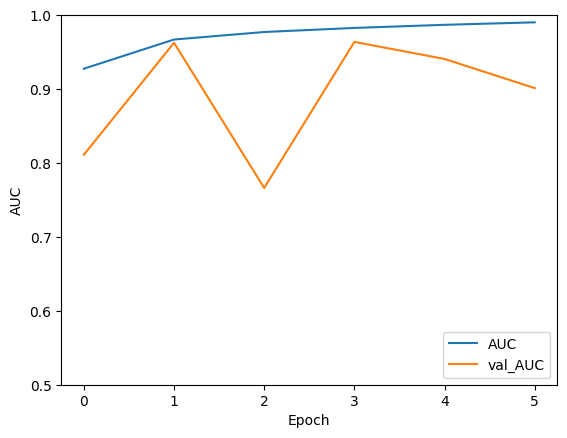

In [ ]:
plt.plot(history.history['AUC'], label='AUC')
plt.plot(history.history['val_AUC'], label = 'val_AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

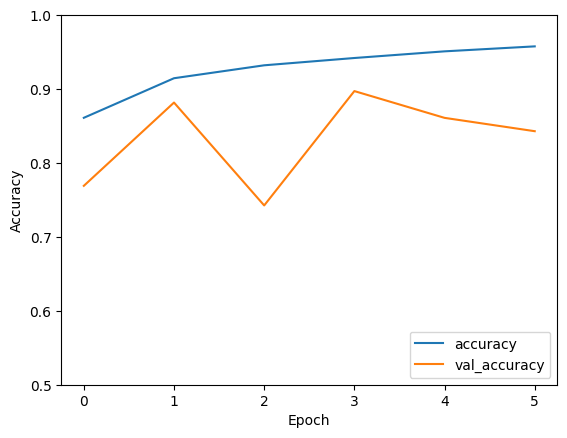

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
test_pred = model.predict(test_flow)
test_pred = test_pred.reshape(-1)
test_df['label'] = test_pred
submit_df = test_df[['id', 'label']]
submit_df.to_csv('/content/submission-complex-early-nadam.csv', index=False)

# 0.8999

449/449 ━━━━━━━━━━━━━━━━━━━━ 103s 225ms/step


# Additional Results and Analysis

I tested two different architectures, added early stopping, and then experimented with optimizers other than Adam. Below are the test scores of each approach when submitted to Kaggle.



*   Simple architecture: 0.8965
*   Simple + Early Stopping: 0.9213
*   Complex architecture + Early Stopping: 0.9390
*   Complex + Early Stop + Lamb Optimizer: 0.9363
*   Complex + Early Stop + NAdam Optimizer: 0.8999

We see that the more complex architecture with early stopping and the Adam optimizer performed the best with the lamb optimizer just behind it. Early stopping did make a meaninful difference when added to the simple architecture. It also saved the more complex models from overfitting which was often occuring after about 5 epochs.

The NAdam optimizer seemed to have less stable performance over the epochs. From the visuals, we see the validation metrics swining back and forth between epochs in a fairly extremem manner not seen in other training runs.

Looking back at the traning runs, I also noticed that the more complicated architectures didn't seem to take any longer than the simpler architecture. Each epoch took approximately 300 seconds for each model training regardless of the architecture. I'd attribute that to the normalization and dropout that were added to the more complex model.







# Conclusion and Discussion

The more complex architecture with the Adam optimizer and early stopping performed the best, followed closely by same configuration using the lamb optimizer. The performance difference from best to worst model was fairly small, approximately 3%.

This was a rewarding project as I was able to achieve reasonable accuracy and see the impact of model architecture and hyperparameter changes.

If I were to continue working on this problem, I'd experiment next with various image transformation techniques and either add more convolution layers or crop the images to focus in on the 32x32 central region that determines the label. With each 3x3 convolution reducing the size be 2 each dimension, we could do 32 convolutions to get down to that central region. That almost certainly isn't necessary but focusing more on that area would likely be helpful.

I would also be interested to see how a pretrained model would perform on this dataset. One reason I chose not to go this route is because a pretrained model trained on natural images wouldn't be a good fit for this dataset of diagnostic images.